In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ccxt

In [3]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    opens = pd.DataFrame(dataframes[0].open).rename(columns={'open':labels[0]})
    for i,coin in enumerate(labels[1:]):
        temp_opens = pd.DataFrame(dataframes[i+1].open).rename(columns={'open':coin})
        opens = opens.merge(temp_opens,how='outer',on='timestamp')
    return (opens)

def load_crypto(days=1000,timeframe='1h',n=30):
    bnc = ccxt.binance()
    symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,since/1000)
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i,:]/price_arr[i-1,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i,:]/price_arr[i-1,:])
    log_returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

In [4]:
crypto_data = pd.read_csv("https://raw.githubusercontent.com/louis-stp/CryptoPortfolio/main/CryptoPrices")
crypto_data['timestamp'] = crypto_data['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))
crypto_data.set_index("timestamp", inplace=True)
crypto_data = crypto_data.loc[:,crypto_data.columns[crypto_data.isna().sum(axis=0)<15000]]
nona = crypto_data.dropna().pct_change()[1:]

In [5]:
training = nona[:7000]
testing = nona[7000:]

In [6]:
regressor = 'BTC'
tickers = list(set(training.columns)-set([regressor]))

In [7]:
X = np.array(training[regressor]).reshape(-1,1)
y = np.array(training[tickers]).reshape(-1,len(tickers)) #second number is the number of stocks I think

In [8]:
#use all data as training data because we arn't predicting anything
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [9]:
coins = {k: [] for k in tickers}
for n in range(len(tickers)):
    lm.fit(X,y[:,n])
    coins[tickers[n]].append(lm.coef_[0])
    coins[tickers[n]].append(lm.score(X,y[:,n]))
    coins[tickers[n]].append(lm.intercept_)

In [10]:
pd.DataFrame(coins, index = ['BTC Beta','R^2','Alpha']).T

,BTC Beta,R^2,Alpha
BCH,1.087504,0.502157,-0.000024
ALGO,1.047170,0.352106,0.000055
SOL,1.092539,0.283078,0.000349
ATOM,1.088813,0.352919,0.000030
ETH,1.036955,0.668076,0.000119
UNI,1.170055,0.399428,0.000184
XRP,1.060069,0.281926,0.000107
FIL,0.783210,0.012161,0.000744
DOT,1.154612,0.437222,0.000098
MATIC,1.260538,0.277656,0.000573


form mean-variance optimized

In [11]:
#should really resample to daily data
t = 12*30*24 #number to makes std and means equivelent to yearly returns so 12 for monthly, 52 for weekly and 252 for daily
posLB = -.1  #lower bound on position exposure
posUB = .5  #upper bound on position exposure

muf = pd.Series(0)
returns = training
mean_vect = training.mean() * t

In [33]:
from scipy.optimize import linprog
m = len(training.columns)
#set equality constraints. I want my positions to sum to 1
A_eq = np.array((1,)*m).reshape(1,-1)
b_eq = [1]

# set bounds on leverage. We can short but we can not go long
short_bounds = (posLB,)*m
long_bounds = (posUB,)*m

bounds = np.vstack([short_bounds,long_bounds]).T

In [34]:
table_min = linprog(c=mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
print("weights",table_min.x)
min_rtn = mean_vect @ table_min.x
print("min rtn", min_rtn)

weights [ 0.5 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.5  0.5 -0.1
 -0.1  0.5 -0.1 -0.1  0.1 -0.1 -0.1  0.5]
min rtn -2.0184203143804167


In [35]:
table_max = linprog(c=-mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
print("weights",table_max.x)
max_rtn = mean_vect @ table_max.x
print("max rtn", max_rtn)

weights [-0.1        -0.1        -0.1         0.5         0.1        -0.1
 -0.1         0.5         0.5        -0.1        -0.1        -0.1
 -0.1         0.5        -0.1        -0.1        -0.1        -0.1
 -0.1         0.5        -0.09999999 -0.1       ]
max rtn 13.364546853343153


In [36]:
from qpsolvers import solve_qp
muP = np.arange(min_rtn * .995,max_rtn * .995, .001)
sdP = np.zeros(len(muP))
weights = np.zeros([len(muP),m])

Cov = 2*np.array(returns.cov())
q_vec = np.zeros(m).reshape(-1,)
G = np.zeros([m,m])
h = np.zeros(m)
A = np.vstack([np.array((1,)*m).reshape(1,-1),mean_vect])

In [37]:
for i in range(len(muP)):
    b = np.array([1,muP[i]])
    weights[i] = solve_qp(P=Cov, q = q_vec, G=G, h=h, A=A, b=b, lb = bounds[:,0], ub = bounds[:,1])
    sdP[i] = np.sqrt(weights[i] @ (Cov/2) @ weights[i]) * np.sqrt(t)

In [38]:
portfolios = pd.DataFrame({'Returns': muP, 'Volatility': sdP,})

for counter, symbol in enumerate(tickers):
    #print(counter, symbol)
    portfolios[symbol+' weight'] = [w[counter] for w in weights]
    
portfolios['Sharpe'] = (portfolios['Returns']-muf.values) / portfolios['Volatility'] #note using monthly returns and vol

In [39]:
tangent = portfolios.iloc[[portfolios.Sharpe.argmax()]]
min_var = portfolios.iloc[[portfolios.Volatility.argmin()]]
efficient_portfolios = portfolios[portfolios['Returns'] >= min_var.Returns.values[0]-.02] #the .02 is arbitrary to see a bit below the min var port too

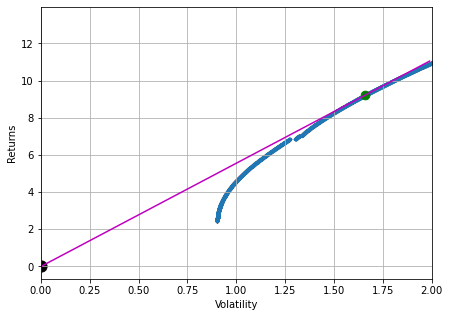

In [40]:
efficient_portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=5, alpha=0.7, grid=True, figsize=[7,5], xlim = (0,2))
plt.scatter(0,muf, marker = '.',s=500, c = 'k')
plt.scatter(tangent.Volatility,tangent.Returns, marker = '.',s=300,c='g')
x = np.arange(0,2,.01)
plt.plot(x,tangent.Sharpe.values[0]*x+muf.values[0],c='m')

In [41]:
tangent

,Returns,Volatility,TRX weight,SOL weight,XLM weight,FIL weight,ETH weight,LINK weight,LUNA weight,BNB weight,...,XRP weight,BCH weight,UNI weight,LTC weight,THETA weight,ALGO weight,ATOM weight,DOT weight,VET weight,Sharpe
11228,9.219672,1.660281,-0.1,0.179097,0.293553,0.192315,0.359207,-0.007856,-0.1,0.30138,...,-0.1,0.327789,-0.1,-0.1,-0.094981,-0.1,-0.1,0.041478,0.080145,5.553079


In [42]:
min_var

,Returns,Volatility,TRX weight,SOL weight,XLM weight,FIL weight,ETH weight,LINK weight,LUNA weight,BNB weight,...,XRP weight,BCH weight,UNI weight,LTC weight,THETA weight,ALGO weight,ATOM weight,DOT weight,VET weight,Sharpe
4455,2.446672,0.903351,0.5,0.438311,0.142748,0.006522,0.033145,-0.000415,-0.033429,0.020802,...,-0.1,-0.05188,0.043897,0.035425,-0.1,0.003768,-0.001396,0.006314,0.002668,2.708441


In [43]:
#https://pyportfolioopt.readthedocs.io/en/latest/

In [44]:
def correlation(dataset,SandP,day):
    return dataset.loc[day[0]:day[1]].corr()[SandP][1:]

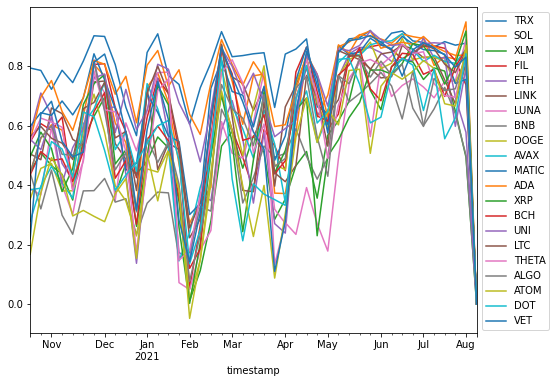

In [45]:
days = training.resample('W-MON').mean().index
corrs_mat = np.zeros([len(days),len(tickers)])
for n in range(len(days)-1):
    corrs_mat[n,:] = correlation(training,'BTC',days.astype(str)[n:n+2]).values
pd.DataFrame(corrs_mat,index=days,columns = tickers).plot(figsize=[8,6])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [46]:
import ccxt

ModuleNotFoundError: No module named 'ccxt'